# Llama Stack RAG with Docling

## Part 1: Setup

In the first section, we prepare the Llama Stack client and set up parameters required
for the RAG worfklows.

In [ ]:
# !pip install -q -U pip llama-stack-client==0.2.* docling[vlm]~=2.25 pillow matplotlib rich

In [1]:
import uuid
from typing import Any, Literal, Optional, Union

import matplotlib.pyplot as plt
import rich
from docling.datamodel.document import DoclingDocument
from docling_core.types.doc import DocItem, RefItem
from llama_stack_client import LlamaStackClient, RAGDocument
from llama_stack_client.types import QueryChunksResponse, QueryResult
from llama_stack_client.types.shared.content_delta import TextDelta, ToolCallDelta
from PIL import ImageDraw
from pydantic import NonNegativeFloat
from pydantic_settings import BaseSettings, SettingsConfigDict
from termcolor import cprint

In [2]:
class Settings(BaseSettings):
    base_url: str

    vdb_provider: str
    vdb_embedding: str
    vdb_embedding_dimension: int
    vdb_embedding_window: int

    inference_model_id: str
    max_tokens: int
    temperature: NonNegativeFloat
    top_p: float
    stream: bool

    model_config = SettingsConfigDict(env_file=".env", env_file_encoding="utf-8")

In [3]:
settings = Settings(
    base_url="http://localhost:8321",
    inference_model_id="meta-llama/Llama-3.2-3B-Instruct",
    max_tokens=4096,
    temperature=0.0,
    top_p=0.95,
    stream=True,
    vdb_provider="milvus",
    vdb_embedding="all-MiniLM-L6-v2",
    vdb_embedding_dimension=384,
    vdb_embedding_window=256,
)
print(settings)

base_url='http://localhost:8321' vdb_provider='milvus' vdb_embedding='all-MiniLM-L6-v2' vdb_embedding_dimension=384 vdb_embedding_window=256 inference_model_id='meta-llama/Llama-3.2-3B-Instruct' max_tokens=4096 temperature=0.0 top_p=0.95 stream=True


In [4]:
if settings.temperature > 0.0:
    strategy = {
        "type": "top_p",
        "temperature": settings.temperature,
        "top_p": settings.top_p,
    }
else:
    strategy = {"type": "greedy"}

# sampling_params will later be used to pass the parameters to Llama Stack Agents/Inference APIs
sampling_params = {
    "strategy": strategy,
    "max_tokens": settings.max_tokens,
}

print(sampling_params)

{'strategy': {'type': 'greedy'}, 'max_tokens': 4096}


In [5]:
client = LlamaStackClient(base_url=settings.base_url)
print(f"Connected to Llama Stack server @ {client.base_url}")

Connected to Llama Stack server @ http://localhost:8321


---

## Part 2: RAG — ingestion and question answering

In this section we will look at RAG, employing different ingestion strategies to explore their behavior and impact on the final answers.

We will first work with an academic paper containing different types of objects
like text, tables, images etc.

Feel free to open the URL and inspect the document.

In [6]:
doclaynet_url = "https://arxiv.org/pdf/2206.01062"

### Ingestion and Q&A using default RAG tool

For simplicity, we are going to create and target a separate vector database ID for
each individual ingestion strategy we try out:

In [7]:
client.vector_dbs.register(
    vector_db_id=(vdb_id := f"test_vector_db_{uuid.uuid4()}"),
    embedding_model=settings.vdb_embedding,
    embedding_dimension=settings.vdb_embedding_dimension,
    provider_id=settings.vdb_provider,
)

VectorDBRegisterResponse(embedding_dimension=384, embedding_model='all-MiniLM-L6-v2', identifier='test_vector_db_6d003808-48e3-493e-8ac2-f1526da1de48', provider_id='milvus', provider_resource_id='test_vector_db_6d003808-48e3-493e-8ac2-f1526da1de48', type='vector_db', access_attributes=None)

Let's now ingest the document using Llama Stack's default RAG tool.

We first define a helper method, to be able to reuse this logic further below:

In [8]:
def ingest_with_default_rag_tool(
    *,
    client: LlamaStackClient,
    vector_db_id: str,
    urls: list[str],
    vdb_embedding_window: int,
) -> None:
    # ingest the documents into the newly created document collection
    my_urls = [(url, "application/pdf") for url in urls]
    documents = [
        RAGDocument(
            document_id=f"num-{i}",
            content=url,
            mime_type=url_type,
            metadata={},
        )
        for i, (url, url_type) in enumerate(my_urls)
    ]
    client.tool_runtime.rag_tool.insert(
        documents=documents,
        vector_db_id=vector_db_id,
        chunk_size_in_tokens=vdb_embedding_window,
    )

Let's now call this function to ingest based on the RAG tool:

In [9]:
ingest_with_default_rag_tool(
    client=client,
    vector_db_id=vdb_id,
    urls=[doclaynet_url],
    vdb_embedding_window=settings.vdb_embedding_window,
)

Let's now look at a RAG query execution:

In [10]:
simple_query = "How many PDF pages does DocLayNet contain?"

We first define a helper method, for being able to reuse in later steps:

In [11]:
def answer_with_rag(
    *,
    client: LlamaStackClient,
    vector_db_id: str,
    sampling_params: dict[str, Any],
    queries: list[str],
    inference_model_id=str,
    stream: bool,
    mode: Literal["rag_tool", "vector_io"] = "rag_tool",
) -> Union[list[QueryChunksResponse], list[QueryResult]]:
    all_responses = []
    for prompt in queries:
        cprint(f"\nUser> {prompt}", "blue")

        # RAG retrieval call
        if mode == "rag_tool":
            retr_response = client.tool_runtime.rag_tool.query(
                content=prompt, vector_db_ids=[vector_db_id]
            )
            prompt_context = retr_response.content
        elif mode == "vector_io":
            retr_response = client.vector_io.query(
                vector_db_id=vector_db_id,
                query=prompt,
            )
            prompt_context = "\n".join([c.content for c in retr_response.chunks])
        else:
            raise ValueError(f"Unknown mode: {mode}")
        all_responses.append(retr_response)

        # the list of messages to be sent to the model must start with the system prompt
        messages = [{"role": "system", "content": "You are a helpful assistant."}]

        # construct the actual prompt to be executed, incorporating the original query and the retrieved content
        extended_prompt = f"Please answer the given query using the context below.\n\nCONTEXT:\n{prompt_context}\n\nQUERY:\n{prompt}"
        messages.append({"role": "user", "content": extended_prompt})

        # use Llama Stack inference API to directly communicate with the desired model
        response = client.inference.chat_completion(
            messages=messages,
            model_id=inference_model_id,
            sampling_params=sampling_params,
            stream=stream,
        )

        # print the response
        cprint("inference> ", color="yellow", end="")
        for chunk in response:
            response_delta = chunk.event.delta
            if isinstance(response_delta, TextDelta):
                cprint(response_delta.text, color="yellow", end="")
            elif isinstance(response_delta, ToolCallDelta):
                cprint(response_delta.tool_call, color="yellow", end="")

    return all_responses

Let's now call this function and see the answer:

In [12]:
all_results = answer_with_rag(
    client=client,
    vector_db_id=vdb_id,
    inference_model_id=settings.inference_model_id,
    stream=settings.stream,
    sampling_params=sampling_params,
    queries=[simple_query],
)


User> How many PDF pages does DocLayNet contain?
inference> According to the knowledge search tool results, DocLayNet contains 80,863 PDF pages.

Let's now try a more advanced query against some table data in the document:

In [13]:
advanced_table_query = (
    "What was the relative occurrence of the label 'Page-header' in the validation set?"
)

By looking at the document page 4, table 1, we can see that the expected answer is
5.06%.

Let's see what response we get back:

In [14]:
all_results = answer_with_rag(
    client=client,
    vector_db_id=vdb_id,
    inference_model_id=settings.inference_model_id,
    stream=settings.stream,
    sampling_params=sampling_params,
    queries=[advanced_table_query],
)


User> What was the relative occurrence of the label 'Page-header' in the validation set?
inference> According to Result 5, the relative occurrence of the label 'Page-header' in the validation set is 72%.

⚠️ The answer may at first appear plausible, but is actually completely incorrect.

The correct one would have been 5.06%, from page 4, table 1.

(Would it not be great to have an easy way to verify these generated answers?
More on that later on this notebook 😉)

<div class="alert alert-warning">
    🤔 Advanced queries, e.g. on tabular data, can quickly bring the Llama Stack's default RAG tool to its limits.
</div>

### Ingestion and Q&A with Docling

Let's now try ingesting with Docling instead:

<div class="alert alert-info">
    🏋️ You have reached an exercise point: roll up your sleeves & try to implement the function below!
</div>

In [15]:
def ingest_with_docling(
    *,
    client: LlamaStackClient,
    vector_db_id: str,
    urls: list[str],
    vdb_embedding: str,
) -> None: ...

In [ ]:
# from p2_solutions import ingest_with_docling

/Users/pva/work/github.com/trustyai-explainability/ai-masterclass-2025/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
client.vector_dbs.register(
    vector_db_id=(vdb_id := f"test_vector_db_{uuid.uuid4()}"),
    embedding_model=settings.vdb_embedding,
    embedding_dimension=settings.vdb_embedding_dimension,
    provider_id=settings.vdb_provider,
)

ingest_with_docling(
    client=client,
    vector_db_id=vdb_id,
    urls=[doclaynet_url],
    vdb_embedding=settings.vdb_embedding,
)

/Users/pva/work/github.com/trustyai-explainability/ai-masterclass-2025/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Token indices sequence length is longer than the specified maximum sequence length for this model (2999 > 512). Running this sequence through the model will result in indexing errors


In [18]:
all_results = answer_with_rag(
    client=client,
    vector_db_id=vdb_id,
    inference_model_id=settings.inference_model_id,
    stream=settings.stream,
    sampling_params=sampling_params,
    queries=[
        simple_query,
        advanced_table_query,
    ],
)


User> How many PDF pages does DocLayNet contain?
inference> According to the text, DocLayNet contains 80863 unique document pages.
User> What was the relative occurrence of the label 'Page-header' in the validation set?
inference> According to Result 3, the relative occurrence of the label 'Page-header' in the validation set is:

* Page-footer: 6.00%
* Page-header: 5.06%

So, the relative occurrence of the label 'Page-header' in the validation set is approximately 5.06%.

<div class="alert alert-success">
    ✅ Docling was able to address both queries successfully thanks to its advanced
    document conversion capabilities.
</div>

___

## Part 3: Multimodal RAG

Let's now try something even more advanced, with a multimodal query touching on visual
understanding of a figure:

In [19]:
docqa_url = "https://arxiv.org/pdf/2311.18481"
multimodal_query = "Which are the main boxes depicted in figure 1?"

Let's try Llama Stack's default RAG tool:

In [20]:
client.vector_dbs.register(
    vector_db_id=(vdb_id := f"test_vector_db_{uuid.uuid4()}"),
    embedding_model=settings.vdb_embedding,
    embedding_dimension=settings.vdb_embedding_dimension,
    provider_id=settings.vdb_provider,
)

ingest_with_default_rag_tool(
    client=client,
    vector_db_id=vdb_id,
    urls=[docqa_url],
    vdb_embedding_window=settings.vdb_embedding_window,
)

In [21]:
all_results = answer_with_rag(
    client=client,
    vector_db_id=vdb_id,
    inference_model_id=settings.inference_model_id,
    stream=settings.stream,
    sampling_params=sampling_params,
    queries=[multimodal_query],
)


User> Which are the main boxes depicted in figure 1?
inference> Unfortunately, I couldn't find any information about a figure 1 in the provided text. The text appears to be a collection of research papers and articles related to document analysis and layout segmentation, but it does not contain an image or a description of a figure 1.

However, based on the context, it seems that the query is likely referring to Figure 1 from one of the documents mentioned in the results. Specifically, I found a mention of "ICDAR 2023 Competition on Robust Layout Segmentation in Corporate Documents" which might be related to Figure 1.

If you could provide more information or clarify which document or paper you are referring to, I may be able to help further.

<div class="alert alert-warning">
    🤔 The default RAG tool cannot address this multimodal query.
</div>

Let's try using Docling out of the box:

In [22]:
client.vector_dbs.register(
    vector_db_id=(vdb_id := f"test_vector_db_{uuid.uuid4()}"),
    embedding_model=settings.vdb_embedding,
    embedding_dimension=settings.vdb_embedding_dimension,
    provider_id=settings.vdb_provider,
)

ingest_with_docling(
    client=client,
    vector_db_id=vdb_id,
    urls=[docqa_url],
    vdb_embedding=settings.vdb_embedding,
)

/Users/pva/work/github.com/trustyai-explainability/ai-masterclass-2025/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


In [23]:
all_results = answer_with_rag(
    client=client,
    vector_db_id=vdb_id,
    inference_model_id=settings.inference_model_id,
    stream=settings.stream,
    sampling_params=sampling_params,
    queries=[multimodal_query],
)


User> Which are the main boxes depicted in figure 1?
inference> Based on the provided context, I was unable to find any information about the main boxes depicted in Figure 1. The text content does not mention Figure 1 or its contents. However, it does provide a simplified sketch of the system architecture for document question-answering pipeline (Figure 1) but does not describe the specific boxes depicted in this figure.

If you could provide more context or clarify which Figure 1 is being referred to, I would be happy to try and assist further.

<div class="alert alert-warning">
    🤔 The default Docling configuration leads to a somewhat improved, but still not fully satisfactory answer.
</div>

Let's instead employ a Docling pipeline with a fit-for-purpose configuration, leveraging:
- a VLM for describing figures,
- a custom serialization strategy using Docling's Serialization API

<div class="alert alert-info">
    🏋️ You have reached an exercise point: roll up your sleeves & try to implement the function below!
</div>

In [24]:
def ingest_with_docling_with_annotations(
    *,
    client: LlamaStackClient,
    vector_db_id: str,
    urls: list[str],
    vdb_embedding: str,
) -> None: ...

In [ ]:
# from p2_solutions import ingest_with_docling_with_annotations

In [26]:
client.vector_dbs.register(
    vector_db_id=(vdb_id := f"test_vector_db_{uuid.uuid4()}"),
    embedding_model=settings.vdb_embedding,
    embedding_dimension=settings.vdb_embedding_dimension,
    provider_id=settings.vdb_provider,
)

ingest_with_docling_with_annotations(
    client=client,
    vector_db_id=vdb_id,
    urls=[docqa_url],
    vdb_embedding=settings.vdb_embedding,
)

/Users/pva/work/github.com/trustyai-explainability/ai-masterclass-2025/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


In [27]:
all_results = answer_with_rag(
    client=client,
    vector_db_id=vdb_id,
    inference_model_id=settings.inference_model_id,
    stream=settings.stream,
    sampling_params=sampling_params,
    queries=[multimodal_query],
)


User> Which are the main boxes depicted in figure 1?
inference> Based on the provided context, I can see that Figure 1 is described in Result 5. The description of Figure 1 mentions three main sections:

1. **Document Conversion**
2. **Information Retrieval**
3. **Response Generation**

These are represented by green, blue, and red boxes respectively in the figure.

<div class="alert alert-success">
    ✅ Docling can also tackle advanced multimodal queries, thanks to its customizability and extensibility.
</div>

___

## Part 4: Visual grounding

Further above we saw examples of answers that were not factually extracted from the
document.

To address this issue and mitigate the impact of hallucinations in RAG, we can
facilitate human verification through grounding.

Docling in particular extracts and maintains detailed metadata (such as bounding boxes,
pages etc.) that enable a strong grounding based on the original document pages.

In [28]:
tech_report_url = "https://arxiv.org/pdf/2408.09869"
viz_query = "Which are the main AI models in Docling?"

To ensure all required information is in place, we need to configure Docling ingestion
such that *page images* are included in the `DoclingDocument`.

<div class="alert alert-info">
    🏋️ You have reached an exercise point: roll up your sleeves & try to implement the function below!
</div>

In [29]:
def ingest_with_docling_for_visual_grounding(
    *,
    client: LlamaStackClient,
    vector_db_id: str,
    urls: list[str],
    vdb_embedding: str,
) -> list[DoclingDocument]: ...

In [ ]:
# from p2_solutions import ingest_with_docling_for_visual_grounding

In [31]:
client.vector_dbs.register(
    vector_db_id=(vdb_id := f"test_vector_db_{uuid.uuid4()}"),
    embedding_model=settings.vdb_embedding,
    embedding_dimension=settings.vdb_embedding_dimension,
    provider_id=settings.vdb_provider,
)

dl_docs = ingest_with_docling_for_visual_grounding(
    client=client,
    vector_db_id=vdb_id,
    urls=[tech_report_url],
    vdb_embedding=settings.vdb_embedding,
)

/Users/pva/work/github.com/trustyai-explainability/ai-masterclass-2025/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


To implement visual grounding we need access to chunk the metadata we originally
provided upon ingestion.

Querying via the RAG tool API (`client.tool_runtime.rag_tool.query()`) currently does
not return all these chunk metadata, so we instead use `client.vector_io.query()`
(controlled by the `mode` parameter in our helper function):

In [32]:
all_results = answer_with_rag(
    client=client,
    vector_db_id=vdb_id,
    inference_model_id=settings.inference_model_id,
    stream=settings.stream,
    sampling_params=sampling_params,
    queries=[viz_query],
    mode="vector_io",
)


User> Which are the main AI models in Docling?
inference> According to the context, the two highly capable AI models released by the team as part of Docling are:

1. A layout analysis model (an accurate object-detector for page elements)
2. TableFormer, a state-of-the-art table structure recognition model.

These models are available for open-source use and can be found in the docling-ibm-models package hosted on Hugging Face.

In [33]:
# first grounding of answer to first (and only) query
print(all_results[0].chunks[0])

Chunk(content='3.2 AI models\nAs part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a state-of-the-art table structure recognition model. We provide the pre-trained weights (hosted on huggingface) and a separate package for the inference code as docling-ibm-models . Both models are also powering the open-access deepsearch-experience, our cloud-native service for knowledge exploration tasks.', metadata={'document_id': '11465328351749295394', 'token_count': 139.0, 'doc_items': ['#/texts/50']})


As seen above, the metadata returned contains all information required for visually
grounding the answer, i.e. the `document_id` and `doc_items` references.

Getting the whole `DoclingDocument` based on that `document_id` in principle implies
that some *document store* should be in place.

👉 For the sake of simplicity, here we will:
- directly reuse `DoclingDocument` object returned by `answer_with_rag` (possible since
  single doc used)
- visualize only the first grounding result

In [34]:
def visualize_chunk_response(
    *,
    chunk_response: QueryChunksResponse,
    dl_doc: DoclingDocument,
    num_chunks_to_viz: Optional[int] = None,
):
    for i, chunk in enumerate(chunk_response.chunks[:num_chunks_to_viz]):
        image_by_page = {}
        print(f"Source {i + 1}:")
        rich.print(chunk)

        for doc_item_ref in chunk.metadata["doc_items"]:
            item = RefItem(cref=doc_item_ref).resolve(doc=dl_doc)
            if isinstance(item, DocItem) and item.prov:
                prov = item.prov[0]  # here we only consider the first provenence
                page_no = prov.page_no
                if img := image_by_page.get(page_no):
                    pass
                else:
                    page = dl_doc.pages[prov.page_no]
                    print(f"  page: {prov.page_no}")
                    img = page.image.pil_image
                    image_by_page[page_no] = img
                bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
                bbox = bbox.normalized(page.size)
                thickness = 2
                padding = thickness + 2
                bbox.l = round(bbox.l * img.width - padding)
                bbox.r = round(bbox.r * img.width + padding)
                bbox.t = round(bbox.t * img.height - padding)
                bbox.b = round(bbox.b * img.height + padding)
                draw = ImageDraw.Draw(img)
                draw.rectangle(
                    xy=bbox.as_tuple(),
                    outline="blue",
                    width=thickness,
                )
        for p in image_by_page:
            img = image_by_page[p]
            plt.figure(figsize=[15, 15])
            plt.imshow(img)
            plt.axis("off")
            plt.show()

Source 1:


Chunk(
    content='3.2 AI models\nAs part of Docling, we initially release two highly capable AI models to the 
open-source community, which have been developed and published recently by our team. The first model is a layout 
analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a 
state-of-the-art table structure recognition model. We provide the pre-trained weights (hosted on huggingface) and 
a separate package for the inference code as docling-ibm-models . Both models are also powering the open-access 
deepsearch-experience, our cloud-native service for knowledge exploration tasks.',
    metadata={'document_id': '11465328351749295394', 'token_count': 139.0, 'doc_items': ['#/texts/50']}
)

  page: 3


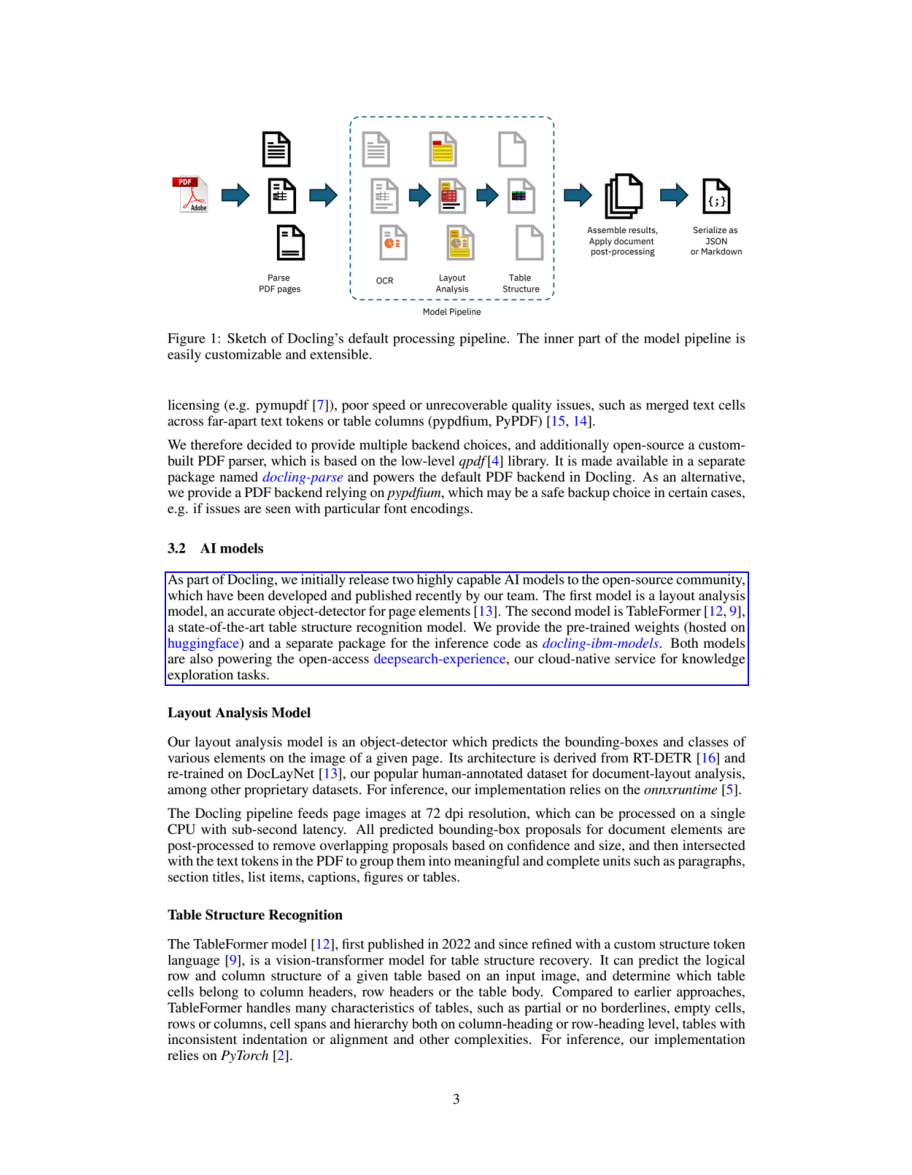

In [35]:
visualize_chunk_response(
    chunk_response=all_results[0],  # only take the first element since single query
    dl_doc=dl_docs[0],  # since single document involved in this example
    num_chunks_to_viz=1,
)

<div class="alert alert-success">
    ✅ Using Docling's advanced document layout extraction capabilities and rich data model, we can provide strong grounding features.
</div>

___

## Part 5: Takeaways

This tutorial demonstrates how to use Docling within Llama Stack, showing how it can
improve Q&A results compared to the default RAG tool, and also showcasing
differentiating features like advanced multimodality and visual grounding.